# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
### Purpose

We'll investigate how resistance against a 2-hidden layer model can provide resistance against a 1-hidden layer model, to see if there is a link between the complexity of a model and the ability to protect against other models.

We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [2]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [3]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import load_data, show_results

## 1. LESS Advanced CNN collateral model

In [4]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.recovering_epochs = 10
        self.advanced_epochs = 20
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

Let's define the model with the describes architecture.

Next, we define the train and test functions. They assume the train_load return two labels: the char and the font of some input.

In the training phase we execute the 3 steps as described aboved.

In the test function, we just test the performance for the main and collateral tasks.

In [15]:
def train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, advanced_collateral):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Split the two targets
        target_char = target[:, 0]
        target_font = target[:, 1]
        
        if not advanced_collateral:
            # Optimize C and F parts of the model with 2 strategies
            if initial_phase:  # Normal optimisation of C
                # Phase 1: Optimise Q + C
                optimizer.zero_grad()
                output = model.forward_char(data)
                loss_char = F.nll_loss(output, target_char)
                loss_char.backward()
                optimizer.step()
            else: # Freezed(Q) optimisation
                # Phase 1: Optimise Freezed(Q) + F
                model.freeze('quad')
                optimizer.zero_grad()
                output_char = model.forward_char(data)
                loss_char = F.nll_loss(output_char, target_char)
                loss_char.backward()
                optimizer.step()
                model.unfreeze()
            # Phase 2: Optimise Freezed(Q) + F
            model.freeze('quad')
            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()

            if perturbate:
                # Optimize Q
                model.freeze('font')
                model.freeze('char')
                optimizer.zero_grad()
                output_char = model.forward_char(data)
                loss_char = F.nll_loss(output_char, target_char)

                output_font = model.forward_font(data)
                loss_font = F.nll_loss(output_font, target_font)

                loss = loss_char - alpha * loss_font
                loss.backward()
                optimizer.step()
                model.unfreeze()
        else:
            loss_char = None
            # advanced_collateral phase: use the CNN
            model.freeze('quad')
            optimizer.zero_grad()
            output = model.forward_font_advanced(data)
            loss_font = F.nll_loss(output, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()
            
        if loss_char is not None:
            loss_char = loss_char.item()
        else:
            loss_char = 0
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Char: {:.6f} Loss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_char, loss_font.item()))

In [16]:
def test(args, model, test_loader, advanced_collateral):
    model.eval()
    correct_char = 0
    correct_font = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Split the two targets
            target_char = target[:, 0]
            target_font = target[:, 1]

            # Char evaluation
            output = model.forward_char(data)
            pred = output.argmax(1, keepdim=True)
            correct_char += pred.eq(target_char.view_as(pred)).sum().item()
            
            # Font evaluation
            if not advanced_collateral:
                output = model.forward_font(data)
            else:
                output = model.forward_font_advanced(data)
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_font.view_as(pred)).sum().item()

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font

Now we can handle the main function. The only thing that really changes is that we now want to have both labels associated to a input item.

In [17]:
def build_tensor_dataset(data, target):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([[i[0][0], i[1][0]] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset

Last the main function !

In [18]:
def main(alpha, hidden_size):
    """
    Perform a learning phase
    """
    torch.manual_seed(1)
    args = Parser()

    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
   
    model = QuadConvNet(hidden_size)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + args.recovering_epochs + args.advanced_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")
        advanced = epoch > args.epochs + args.sabotage_epochs + args.recovering_epochs
        if advanced:
            print('(advanced)')
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, advanced)
        test_perf_char, test_perf_font = test(args, model, test_loader, advanced)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font, model

We first test with our best trade-off (alpha = 1.5)

In [28]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self, hidden_size):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, N_CHARS)
        
        # --- FFN for font families
        self.lin5 = nn.Linear(8, 32)
        self.lin6 = nn.Linear(32, 16)
        self.lin7 = nn.Linear(16, N_FONTS)
        
        # --- FFN for font families advanced
        self.lin3 = nn.Linear(8, hidden_size)
        self.lin4 = nn.Linear(hidden_size, N_FONTS)
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- FFN
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        
    def conv_font(self, x):
        # --- FFN
        x = F.relu(self.lin5(x))
        x = F.relu(self.lin6(x))
        x = self.lin7(x)
        return x
    
    def conv_font_advanced(self, x):
        # --- FFN
        x = F.relu(self.lin3(x))
        x = self.lin4(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font_advanced(self, x):
        x = self.quad(x)
        x = self.conv_font_advanced(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.lin5, self.lin6, self.lin7]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

In [29]:
results = {}
alpha = 1.5
hidden_size = 64
test_perfs_char_clean, test_perfs_font_clean, model_clean = main(alpha, hidden_size)
results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_clean
results[f"Collateral task with hidden layer size={hidden_size}"] = test_perfs_font_clean

Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.308304 Loss Font: 1.621778
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.218641 Loss Font: 1.618564
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.136615 Loss Font: 1.630733
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 3.101843 Loss Font: 1.636605
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.721429 Loss Font: 1.629614
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.604940 Loss Font: 1.631876
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.314152 Loss Font: 1.627491
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 1.853978 Loss Font: 1.638978
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.645774 Loss Font: 1.572160
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.632967 Loss Font: 1.577503

Test set: Accuracy Char : 4987/10000 (49.87%)
          Accuracy Font : 2517/10000 (25.17%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 1.427133 Loss Font: 1.542305
Train Epoch

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.052119 Loss Font: 1.101688
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.356011 Loss Font: 1.101969
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.119840 Loss Font: 1.284787
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.108402 Loss Font: 1.205962

Test set: Accuracy Char : 9262/10000 (92.62%)
          Accuracy Font : 4707/10000 (47.07%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.163475 Loss Font: 1.027432
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.172473 Loss Font: 1.607963
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.269086 Loss Font: 1.656199
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.156161 Loss Font: 1.537860
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.168845 Loss Font: 1.551778
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.128068 Loss Font: 1.450801
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.286149 Loss Font: 1.505695
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.159474 Loss Fon

Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.783474 Loss Font: 1.518862
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.254402 Loss Font: 1.557496
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.103311 Loss Font: 1.603013
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.166021 Loss Font: 1.608503
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.083998 Loss Font: 1.632595
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.142464 Loss Font: 1.509046
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.325944 Loss Font: 1.597733
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.113786 Loss Font: 1.525900
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.460928 Loss Font: 1.517801

Test set: Accuracy Char : 9121/10000 (91.21%)
          Accuracy Font : 2877/10000 (28.77%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.354443 Loss Font: 1.587411
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.065235 Loss Font: 1.567999
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.256271 Loss Font: 1.589882
Tr

Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.158635 Loss Font: 1.423505

Test set: Accuracy Char : 9173/10000 (91.73%)
          Accuracy Font : 3516/10000 (35.16%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.221624 Loss Font: 1.383535
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.073463 Loss Font: 1.426762
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.133011 Loss Font: 1.403433
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.179239 Loss Font: 1.475411
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.298767 Loss Font: 1.483282
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.363552 Loss Font: 1.503261
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.157757 Loss Font: 1.504128
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.114915 Loss Font: 1.430504
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.246418 Loss Font: 1.527242
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.039532 Loss Font: 1.431834

Test set: Accuracy Char : 9234/10000 (92.34%)
          Accuracy Font : 3572

Train Epoch: 39 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.484420
Train Epoch: 39 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.525229
Train Epoch: 39 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.476760
Train Epoch: 39 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.518702

Test set: Accuracy Char : 9223/10000 (92.23%)
          Accuracy Font : 3296/10000 (32.96%)
(advanced)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.516567
Train Epoch: 40 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.586852
Train Epoch: 40 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.485609
Train Epoch: 40 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.482986
Train Epoch: 40 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.586321
Train Epoch: 40 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.390328
Train Epoch: 40 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.487116
Train Epoch: 40 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font:

Train Epoch: 49 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.406843
Train Epoch: 49 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.516700
Train Epoch: 49 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.387526
Train Epoch: 49 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.363057
Train Epoch: 49 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.522393
Train Epoch: 49 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.324016
Train Epoch: 49 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.323363
Train Epoch: 49 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.335054

Test set: Accuracy Char : 9223/10000 (92.23%)
          Accuracy Font : 3657/10000 (36.57%)
(advanced)
Train Epoch: 50 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.367713
Train Epoch: 50 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.581960
Train Epoch: 50 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.400159
Train Epoch: 50 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font:

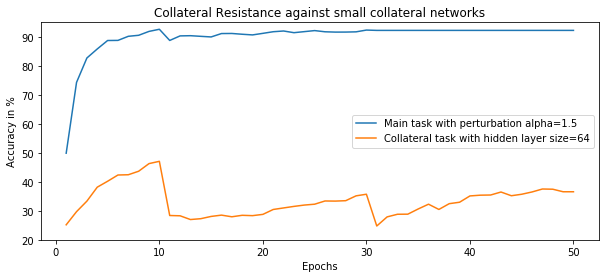

In [30]:
show_results(results, "Collateral Resistance against small collateral networks", ymin=20, ymax=95)

**Observation** So we have a very good defence against the collateral 1-hidden layer model, since we achieve `36.3%` accuracy (which is to compare to the `35.6%` and `35.2%` in Part 11 & Part 12 for the same model.

For the sake of comparison, we observe how the smaller models perform:

In [31]:
hidden_sizes = [8, 16, 32]
for hidden_size in hidden_sizes:
    test_perfs_char_clean, test_perfs_font_clean, model_clean = main(alpha, hidden_size)
    results[f"Collateral task with hidden layer size={hidden_size}"] = test_perfs_font_clean

Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.288354 Loss Font: 1.614418
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.240178 Loss Font: 1.644464
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.242455 Loss Font: 1.632856
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.991543 Loss Font: 1.628450
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.900698 Loss Font: 1.613586
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.296860 Loss Font: 1.628452
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.223376 Loss Font: 1.604023
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 1.843425 Loss Font: 1.637989
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.653617 Loss Font: 1.644035
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.592215 Loss Font: 1.543463

Test set: Accuracy Char : 4814/10000 (48.14%)
          Accuracy Font : 2584/10000 (25.84%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 1.464758 Loss Font: 1.584869
Train Epoch

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.052591 Loss Font: 1.200012
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.182174 Loss Font: 1.385752
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.168062 Loss Font: 1.180603
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.170273 Loss Font: 1.140431

Test set: Accuracy Char : 9234/10000 (92.34%)
          Accuracy Font : 4891/10000 (48.91%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.278601 Loss Font: 1.218600
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.255600 Loss Font: 1.625903
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.353912 Loss Font: 1.611180
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.410713 Loss Font: 1.599218
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.242157 Loss Font: 1.492611
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.193013 Loss Font: 1.545858
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.177505 Loss Font: 1.575221
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.180415 Loss Fon

Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.187361 Loss Font: 1.543753
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.338240 Loss Font: 1.624255
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.169041 Loss Font: 1.597787
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.213583 Loss Font: 1.534659
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.127549 Loss Font: 1.548919
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.176547 Loss Font: 1.546880
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.259046 Loss Font: 1.556286
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.116270 Loss Font: 1.658871
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.344144 Loss Font: 1.564861

Test set: Accuracy Char : 9169/10000 (91.69%)
          Accuracy Font : 2831/10000 (28.31%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.310757 Loss Font: 1.591459
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.346544 Loss Font: 1.549351
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.189996 Loss Font: 1.490310
Tr

Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.407355 Loss Font: 1.552266

Test set: Accuracy Char : 9152/10000 (91.52%)
          Accuracy Font : 3511/10000 (35.11%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.163260 Loss Font: 1.518724
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.193369 Loss Font: 1.358320
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.216212 Loss Font: 1.407885
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.133599 Loss Font: 1.482795
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.376425 Loss Font: 1.450209
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.218170 Loss Font: 1.510998
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.141788 Loss Font: 1.470138
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.119240 Loss Font: 1.434469
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.093308 Loss Font: 1.502596
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.098322 Loss Font: 1.449086

Test set: Accuracy Char : 9194/10000 (91.94%)
          Accuracy Font : 3546

Train Epoch: 39 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.586575
Train Epoch: 39 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.594341
Train Epoch: 39 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.584307
Train Epoch: 39 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.609954

Test set: Accuracy Char : 9178/10000 (91.78%)
          Accuracy Font : 2382/10000 (23.82%)
(advanced)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.579612
Train Epoch: 40 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.603662
Train Epoch: 40 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.590818
Train Epoch: 40 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.632589
Train Epoch: 40 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.571963
Train Epoch: 40 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.588329
Train Epoch: 40 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.599469
Train Epoch: 40 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font:

Train Epoch: 49 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.579279
Train Epoch: 49 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.604923
Train Epoch: 49 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.597935
Train Epoch: 49 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.613708
Train Epoch: 49 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.547682
Train Epoch: 49 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.559427
Train Epoch: 49 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.618489
Train Epoch: 49 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.600655

Test set: Accuracy Char : 9178/10000 (91.78%)
          Accuracy Font : 2446/10000 (24.46%)
(advanced)
Train Epoch: 50 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.600763
Train Epoch: 50 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.588814
Train Epoch: 50 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.603371
Train Epoch: 50 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font:

Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.150001 Loss Font: 1.318425

Test set: Accuracy Char : 9241/10000 (92.41%)
          Accuracy Font : 4693/10000 (46.93%)
(initial phase)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.508980 Loss Font: 1.248856
Train Epoch: 9 [6400/60000 (11%)]	Loss Char: 0.192767 Loss Font: 1.219216
Train Epoch: 9 [12800/60000 (21%)]	Loss Char: 0.261241 Loss Font: 1.322383
Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.086817 Loss Font: 1.256620
Train Epoch: 9 [25600/60000 (43%)]	Loss Char: 0.341108 Loss Font: 1.346416
Train Epoch: 9 [32000/60000 (53%)]	Loss Char: 0.146910 Loss Font: 1.343742
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.478523 Loss Font: 1.112249
Train Epoch: 9 [44800/60000 (75%)]	Loss Char: 0.061747 Loss Font: 1.062347
Train Epoch: 9 [51200/60000 (85%)]	Loss Char: 0.151431 Loss Font: 1.317811
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.297755 Loss Font: 1.238817

Test set: Accuracy Char : 9204/10000 (92.04%)
          Accuracy Font :

Train Epoch: 18 [25600/60000 (43%)]	Loss Char: 0.278540 Loss Font: 1.528089
Train Epoch: 18 [32000/60000 (53%)]	Loss Char: 0.105247 Loss Font: 1.559964
Train Epoch: 18 [38400/60000 (64%)]	Loss Char: 0.294444 Loss Font: 1.561518
Train Epoch: 18 [44800/60000 (75%)]	Loss Char: 0.226021 Loss Font: 1.512500
Train Epoch: 18 [51200/60000 (85%)]	Loss Char: 0.203008 Loss Font: 1.543862
Train Epoch: 18 [57600/60000 (96%)]	Loss Char: 0.109204 Loss Font: 1.552562

Test set: Accuracy Char : 9104/10000 (91.04%)
          Accuracy Font : 2814/10000 (28.14%)
(perturbate)
Train Epoch: 19 [0/60000 (0%)]	Loss Char: 0.251106 Loss Font: 1.538079
Train Epoch: 19 [6400/60000 (11%)]	Loss Char: 0.125842 Loss Font: 1.560376
Train Epoch: 19 [12800/60000 (21%)]	Loss Char: 0.255511 Loss Font: 1.505576
Train Epoch: 19 [19200/60000 (32%)]	Loss Char: 0.123086 Loss Font: 1.511532
Train Epoch: 19 [25600/60000 (43%)]	Loss Char: 0.351031 Loss Font: 1.518489
Train Epoch: 19 [32000/60000 (53%)]	Loss Char: 0.127955 Loss Fon

Train Epoch: 28 [6400/60000 (11%)]	Loss Char: 0.079069 Loss Font: 1.508659
Train Epoch: 28 [12800/60000 (21%)]	Loss Char: 0.391706 Loss Font: 1.489963
Train Epoch: 28 [19200/60000 (32%)]	Loss Char: 0.144816 Loss Font: 1.515549
Train Epoch: 28 [25600/60000 (43%)]	Loss Char: 0.093687 Loss Font: 1.514383
Train Epoch: 28 [32000/60000 (53%)]	Loss Char: 0.087047 Loss Font: 1.420268
Train Epoch: 28 [38400/60000 (64%)]	Loss Char: 0.259149 Loss Font: 1.413668
Train Epoch: 28 [44800/60000 (75%)]	Loss Char: 0.204643 Loss Font: 1.525598
Train Epoch: 28 [51200/60000 (85%)]	Loss Char: 0.145484 Loss Font: 1.424039
Train Epoch: 28 [57600/60000 (96%)]	Loss Char: 0.208179 Loss Font: 1.437666

Test set: Accuracy Char : 9193/10000 (91.93%)
          Accuracy Font : 3459/10000 (34.59%)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.378312 Loss Font: 1.475870
Train Epoch: 29 [6400/60000 (11%)]	Loss Char: 0.299706 Loss Font: 1.408965
Train Epoch: 29 [12800/60000 (21%)]	Loss Char: 0.112098 Loss Font: 1.448133
Tr

Train Epoch: 37 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.571560

Test set: Accuracy Char : 9083/10000 (90.83%)
          Accuracy Font : 2318/10000 (23.18%)
(advanced)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.591103
Train Epoch: 38 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.608886
Train Epoch: 38 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.602929
Train Epoch: 38 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.579206
Train Epoch: 38 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.589087
Train Epoch: 38 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.568367
Train Epoch: 38 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.604823
Train Epoch: 38 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.593950
Train Epoch: 38 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.580115
Train Epoch: 38 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.574236

Test set: Accuracy Char : 9083/10000 (90.83%)
          Accuracy 

Train Epoch: 47 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.633321
Train Epoch: 47 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.616187
Train Epoch: 47 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.587042
Train Epoch: 47 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.591951
Train Epoch: 47 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.596185
Train Epoch: 47 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.580520

Test set: Accuracy Char : 9083/10000 (90.83%)
          Accuracy Font : 2393/10000 (23.93%)
(advanced)
Train Epoch: 48 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.588804
Train Epoch: 48 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.578901
Train Epoch: 48 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.560280
Train Epoch: 48 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.580726
Train Epoch: 48 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.570690
Train Epoch: 48 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font:


Test set: Accuracy Char : 8963/10000 (89.63%)
          Accuracy Font : 4276/10000 (42.76%)
(initial phase)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.261718 Loss Font: 1.302566
Train Epoch: 7 [6400/60000 (11%)]	Loss Char: 0.334594 Loss Font: 1.352653
Train Epoch: 7 [12800/60000 (21%)]	Loss Char: 0.418373 Loss Font: 1.265712
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.240532 Loss Font: 1.262123
Train Epoch: 7 [25600/60000 (43%)]	Loss Char: 0.348960 Loss Font: 1.470281
Train Epoch: 7 [32000/60000 (53%)]	Loss Char: 0.185491 Loss Font: 1.485065
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.285831 Loss Font: 1.300243
Train Epoch: 7 [44800/60000 (75%)]	Loss Char: 0.487131 Loss Font: 1.345238
Train Epoch: 7 [51200/60000 (85%)]	Loss Char: 0.241973 Loss Font: 1.244319
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.157812 Loss Font: 1.299932

Test set: Accuracy Char : 9151/10000 (91.51%)
          Accuracy Font : 4504/10000 (45.04%)
(initial phase)
Train Epoch: 8 [0/60000 (0%)]	Loss Cha

Train Epoch: 16 [32000/60000 (53%)]	Loss Char: 0.130791 Loss Font: 1.564409
Train Epoch: 16 [38400/60000 (64%)]	Loss Char: 0.142703 Loss Font: 1.516982
Train Epoch: 16 [44800/60000 (75%)]	Loss Char: 0.072801 Loss Font: 1.546105
Train Epoch: 16 [51200/60000 (85%)]	Loss Char: 0.117232 Loss Font: 1.552257
Train Epoch: 16 [57600/60000 (96%)]	Loss Char: 0.269541 Loss Font: 1.513647

Test set: Accuracy Char : 8923/10000 (89.23%)
          Accuracy Font : 2814/10000 (28.14%)
(perturbate)
Train Epoch: 17 [0/60000 (0%)]	Loss Char: 0.413941 Loss Font: 1.509773
Train Epoch: 17 [6400/60000 (11%)]	Loss Char: 0.120157 Loss Font: 1.469939
Train Epoch: 17 [12800/60000 (21%)]	Loss Char: 0.119429 Loss Font: 1.522292
Train Epoch: 17 [19200/60000 (32%)]	Loss Char: 0.247396 Loss Font: 1.554918
Train Epoch: 17 [25600/60000 (43%)]	Loss Char: 0.091932 Loss Font: 1.564393
Train Epoch: 17 [32000/60000 (53%)]	Loss Char: 0.197400 Loss Font: 1.579531
Train Epoch: 17 [38400/60000 (64%)]	Loss Char: 0.368118 Loss Fon

Train Epoch: 26 [6400/60000 (11%)]	Loss Char: 0.142635 Loss Font: 1.480004
Train Epoch: 26 [12800/60000 (21%)]	Loss Char: 0.257867 Loss Font: 1.497677
Train Epoch: 26 [19200/60000 (32%)]	Loss Char: 0.043842 Loss Font: 1.511016
Train Epoch: 26 [25600/60000 (43%)]	Loss Char: 0.249709 Loss Font: 1.578616
Train Epoch: 26 [32000/60000 (53%)]	Loss Char: 0.257165 Loss Font: 1.536707
Train Epoch: 26 [38400/60000 (64%)]	Loss Char: 0.195118 Loss Font: 1.539036
Train Epoch: 26 [44800/60000 (75%)]	Loss Char: 0.089576 Loss Font: 1.455808
Train Epoch: 26 [51200/60000 (85%)]	Loss Char: 0.287228 Loss Font: 1.539515
Train Epoch: 26 [57600/60000 (96%)]	Loss Char: 0.216576 Loss Font: 1.532872

Test set: Accuracy Char : 9123/10000 (91.23%)
          Accuracy Font : 3400/10000 (34.00%)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.249458 Loss Font: 1.460064
Train Epoch: 27 [6400/60000 (11%)]	Loss Char: 0.282086 Loss Font: 1.465679
Train Epoch: 27 [12800/60000 (21%)]	Loss Char: 0.440152 Loss Font: 1.405086
Tr

Train Epoch: 35 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.582131
Train Epoch: 35 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.546276

Test set: Accuracy Char : 9192/10000 (91.92%)
          Accuracy Font : 2914/10000 (29.14%)
(advanced)
Train Epoch: 36 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.575674
Train Epoch: 36 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.571648
Train Epoch: 36 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.578410
Train Epoch: 36 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.567915
Train Epoch: 36 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.493488
Train Epoch: 36 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.469183
Train Epoch: 36 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.615840
Train Epoch: 36 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.526735
Train Epoch: 36 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.598274
Train Epoch: 36 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font:

Train Epoch: 45 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.549108
Train Epoch: 45 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.473475
Train Epoch: 45 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.547857
Train Epoch: 45 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.488462
Train Epoch: 45 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.542789
Train Epoch: 45 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.481558
Train Epoch: 45 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.578398

Test set: Accuracy Char : 9192/10000 (91.92%)
          Accuracy Font : 3284/10000 (32.84%)
(advanced)
Train Epoch: 46 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.545024
Train Epoch: 46 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.455946
Train Epoch: 46 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.393182
Train Epoch: 46 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.542557
Train Epoch: 46 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font:

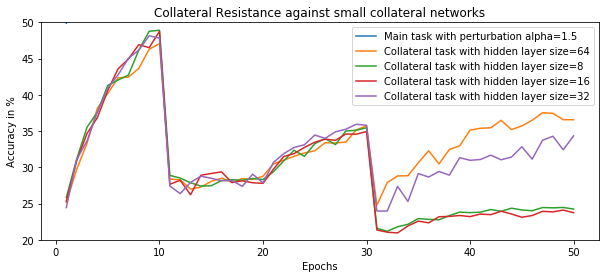

In [32]:
show_results(results, "Collateral Resistance against small collateral networks", ymin=20, ymax=50)

Smaller models are opposed a very resistance, which is line with our results of parts 11 & 12.

So basically if a Task T is resistant to a Collateral Task T' with a model M, then for all models M' < M, T will be resistant to T' with M'.

```
# --- FFN for font families
self.lin5 = nn.Linear(8, 32)
self.lin6 = nn.Linear(32, 16)
self.lin7 = nn.Linear(16, N_FONTS)

hidden_size = 64
# --- FFN for font families advanced
self.lin3 = nn.Linear(8, hidden_size)
self.lin4 = nn.Linear(hidden_size, N_FONTS)
```

One thing to notice is that, for the biggest model with 1-hidden layer size of 64, the two models (the one resistance is built one, and the one it is evaluated on), have exactly the same nummber of parameters, 904.

In [38]:
8*33 + 32*17 + 16*6, 8*65 + 64*6

(904, 904)

## Conclusion

Complexity of the collateral model seems to be a key factor: if it higher then the model on which resistance to CL has been built, then it will succeed in doing "acceptable" predictions.